In [48]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tjml-2022-2023-neural-network-competition/sample.csv
/kaggle/input/tjml-2022-2023-neural-network-competition/train.csv
/kaggle/input/tjml-2022-2023-neural-network-competition/test.csv


**Importing Libraries**

In [49]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from tensorflow.keras import Model,layers,optimizers,losses, Sequential
import random
import tensorflow_addons as tfa
from sklearn import metrics

**Loading the Data In**

In [50]:
# Loading in training data (train.csv) and creating X and y dataframes
df = pd.read_csv("/kaggle/input/tjml-2022-2023-neural-network-competition/train.csv")
X_df = df.drop(["5"], axis=1)
y_df = df["5"]

# Converting pandas dataframes to numpy arrays
X_arr = X_df.to_numpy()
y_arr = y_df.to_numpy()

# Reshaping into squarical image dimensions
X_arr = X_arr.reshape(59999, 28, 28)


In [51]:
# Verifying Proper Dimensions
print(X_arr.shape)
print(y_arr.shape)

(59999, 28, 28)
(59999,)


**Splitting data into training and validation**

In [52]:
X_train, X_val, y_train, y_val = train_test_split(X_arr, y_arr, test_size=0.2)

**Image Augmentation Applied To Improve Data Variation and in turn, model performance**

In [53]:
#ImageAugmentation Class 
class ImageAugmentation():
    def __init__(self,dataset):
        self.main_dataset = dataset
        
    def rotation(self,image,label):
        randAngle = random.randint(-10, 10) * np.pi / 180
        image = tfa.image.rotate(image,randAngle)
        return image, label
    
    def apply_augmentation(self):
        dataset_b = self.main_dataset.map(self.rotation)
        out_dataset= self.main_dataset.concatenate(dataset_b)
        return out_dataset

**Creating a training and validation dataset as TensorFlow datasets and applying image augmentation**

In [54]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(64).prefetch(-1)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(8).prefetch(-1)

image_augmentation = ImageAugmentation(train_dataset)
train_dataset = image_augmentation.apply_augmentation()

In [55]:
# Verifying validation and training dataset shapes
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(47999, 28, 28)
(47999,)
(12000, 28, 28)
(12000,)


**Helper Functions for Convolutional Neural Network**

In [56]:
def convBlock(num_filters=[128,64],kernel_size=[7,5],stride=2):
    def customLayer(inputs):
        x = layers.Conv2D(num_filters[0],kernel_size[0],activation='relu')(inputs)
        x = layers.Conv2D(num_filters[1],kernel_size[1],activation='relu')(x)
        x = layers.MaxPooling2D(stride)(x)
        x = layers.BatchNormalization()(x)
        return x
    return customLayer



In [57]:
def cnnModel(input_shape,num_classes):
    inputs = layers.Input(input_shape)
    x = convBlock(num_filters=[128,64],kernel_size=[7,5],stride=2)(inputs)
    x = layers.Dropout(0.4)(x)
    x = convBlock(num_filters=[64,32],kernel_size=[5,3],stride=2)(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512,activation='relu')(x)
    x = layers.Dense(128,activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    output = layers.Dense(num_classes,activation='softmax')(x)
    return Model(inputs=[inputs],outputs=[output])

**Model Creation, input size: 28x28 images**

In [58]:
model = cnnModel((28, 28, 1),num_classes=10)
model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 22, 22, 128)       6400      
                                                                 
 conv2d_5 (Conv2D)           (None, 18, 18, 64)        204864    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 9, 64)         0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 9, 9, 64)         256       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 9, 9, 64)          0   

**Initializing Hyperparameters**

In [59]:
EPOCHS=25
BATCH_SIZE=64
early_stopping=tf.keras.callbacks.EarlyStopping(patience=7,restore_best_weights=True)

**Model Fitting on Training and Validation Data**

In [60]:
history = model.fit(train_dataset,epochs=EPOCHS,batch_size=BATCH_SIZE,validation_data=val_dataset,callbacks=[early_stopping])

Epoch 1/25


2023-03-19 20:13:32.332870: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1500/1500 [==============================] - 21s 12ms/step - loss: 0.1915 - accuracy: 0.9435 - val_loss: 0.0573 - val_accuracy: 0.9856
Epoch 2/25
1500/1500 [==============================] - 18s 12ms/step - loss: 0.0720 - accuracy: 0.9808 - val_loss: 0.0595 - val_accuracy: 0.9862
Epoch 3/25
1500/1500 [==============================] - 18s 12ms/step - loss: 0.0546 - accuracy: 0.9857 - val_loss: 0.0561 - val_accuracy: 0.9868
Epoch 4/25
1500/1500 [==============================] - 18s 12ms/step - loss: 0.0465 - accuracy: 0.9879 - val_loss: 0.0515 - val_accuracy: 0.9882
Epoch 5/25
1500/1500 [==============================] - 18s 12ms/step - loss: 0.0377 - accuracy: 0.9901 - val_loss: 0.0408 - val_accuracy: 0.9909
Epoch 6/25
1500/1500 [==============================] - 18s 12ms/step - loss: 0.0361 - accuracy: 0.9906 - val_loss: 0.0443 - val_accuracy: 0.9906
Epoch 7/25
1500/1500 [==============================] - 18s 12ms/step - loss: 0.0289 - accuracy: 0.9923 - val_loss: 0.0458 - val_accura

**Model Evaluation and Visualizations**

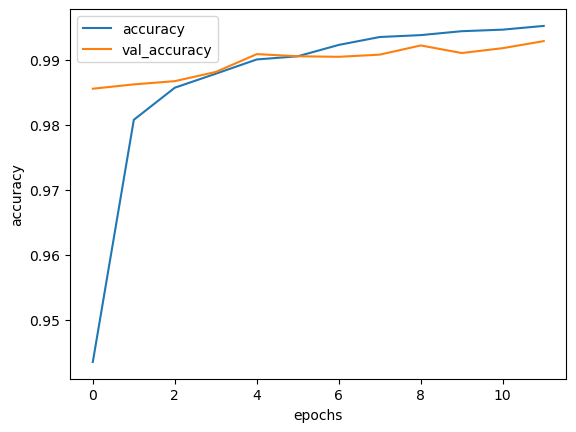

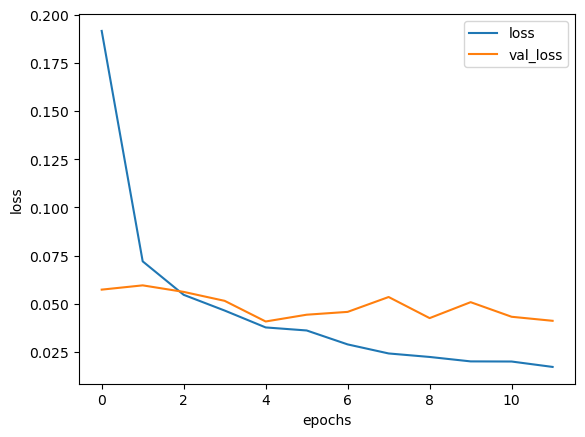

In [61]:
def plot_graph(history,name):
    plt.plot(history[name],label=name)
    plt.plot(history[f'val_{name}'],label=f'val_{name}')
    plt.xlabel('epochs')
    plt.ylabel(name)
    plt.legend()
    plt.show()

plot_graph(history.history,'accuracy')
plot_graph(history.history,'loss')

In [62]:
def get_label(pred):
    label_index = 0
    max_precentage = 0
    for i,p in enumerate(pred):
        if(max_precentage < p):
            max_precentage = p
            label_index = i
    return label_index

375/375 [==============================] - 1s 2ms/step


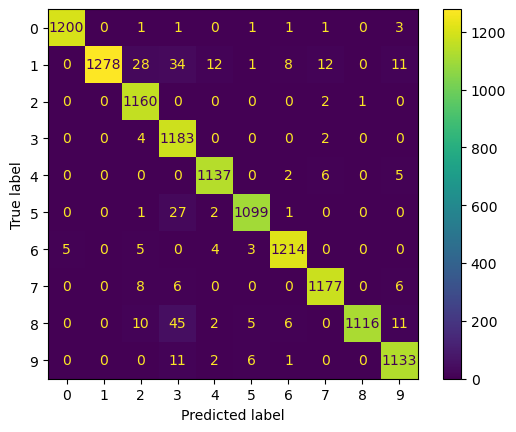

In [63]:
pred = model.predict(X_val * 255)
y_pred_val = [get_label(p) for p in pred]
metrics.ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val)

**Autoencoder Implementation for Aid in Data Visualization and Patter Recognition**

In [81]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as L

import numpy as np
import pandas as pd

In [82]:
encoder = keras.Sequential()

encoder.add(L.InputLayer([784]))
encoder.add(L.Dense(500, activation='selu'))
encoder.add(L.Dense(300, activation='selu'))
encoder.add(L.Dense(2, activation='selu', name='latent'))

encoder.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 500)               392500    
                                                                 
 dense_31 (Dense)            (None, 300)               150300    
                                                                 
 latent (Dense)              (None, 2)                 602       
                                                                 
Total params: 543,402
Trainable params: 543,402
Non-trainable params: 0
_________________________________________________________________


In [83]:
decoder = keras.Sequential()

decoder.add(L.InputLayer([2]))
decoder.add(L.Dense(300, activation='selu'))
decoder.add(L.Dense(500, activation='selu'))
decoder.add(L.Dense(784, activation='sigmoid', name='reconstruction'))

decoder.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 300)               900       
                                                                 
 dense_33 (Dense)            (None, 500)               150500    
                                                                 
 reconstruction (Dense)      (None, 784)               392784    
                                                                 
Total params: 544,184
Trainable params: 544,184
Non-trainable params: 0
_________________________________________________________________


In [84]:
autoencoder = keras.Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1.5))

In [85]:
from tensorflow.keras.datasets.mnist import load_data

(X_train, y_train), (X_val, y_val) = load_data()
X_train = (np.array(X_train)/255.).reshape(-1, 784)
X_val = (np.array(X_val)/255.).reshape(-1, 784)

In [86]:
history2 = autoencoder.fit(X_train, X_train, validation_data=(X_val, X_val), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.1713 - val_loss: 0.0892
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0748 - val_loss: 0.0704
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0693 - val_loss: 0.0689
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0684 - val_loss: 0.0683
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0679 - val_loss: 0.0679
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0675 - val_loss: 0.0674
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0671 - val_loss: 0.0670
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0667 - val_loss: 0.0667
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0665 - val_loss: 0.0664
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.066

In [87]:
X_val_latent = encoder.predict(X_val)

313/313 [==============================] - 1s 2ms/step


(7.293948602676392, 41.82046275138855, -1.7777136445045472, -1.333051335811615)

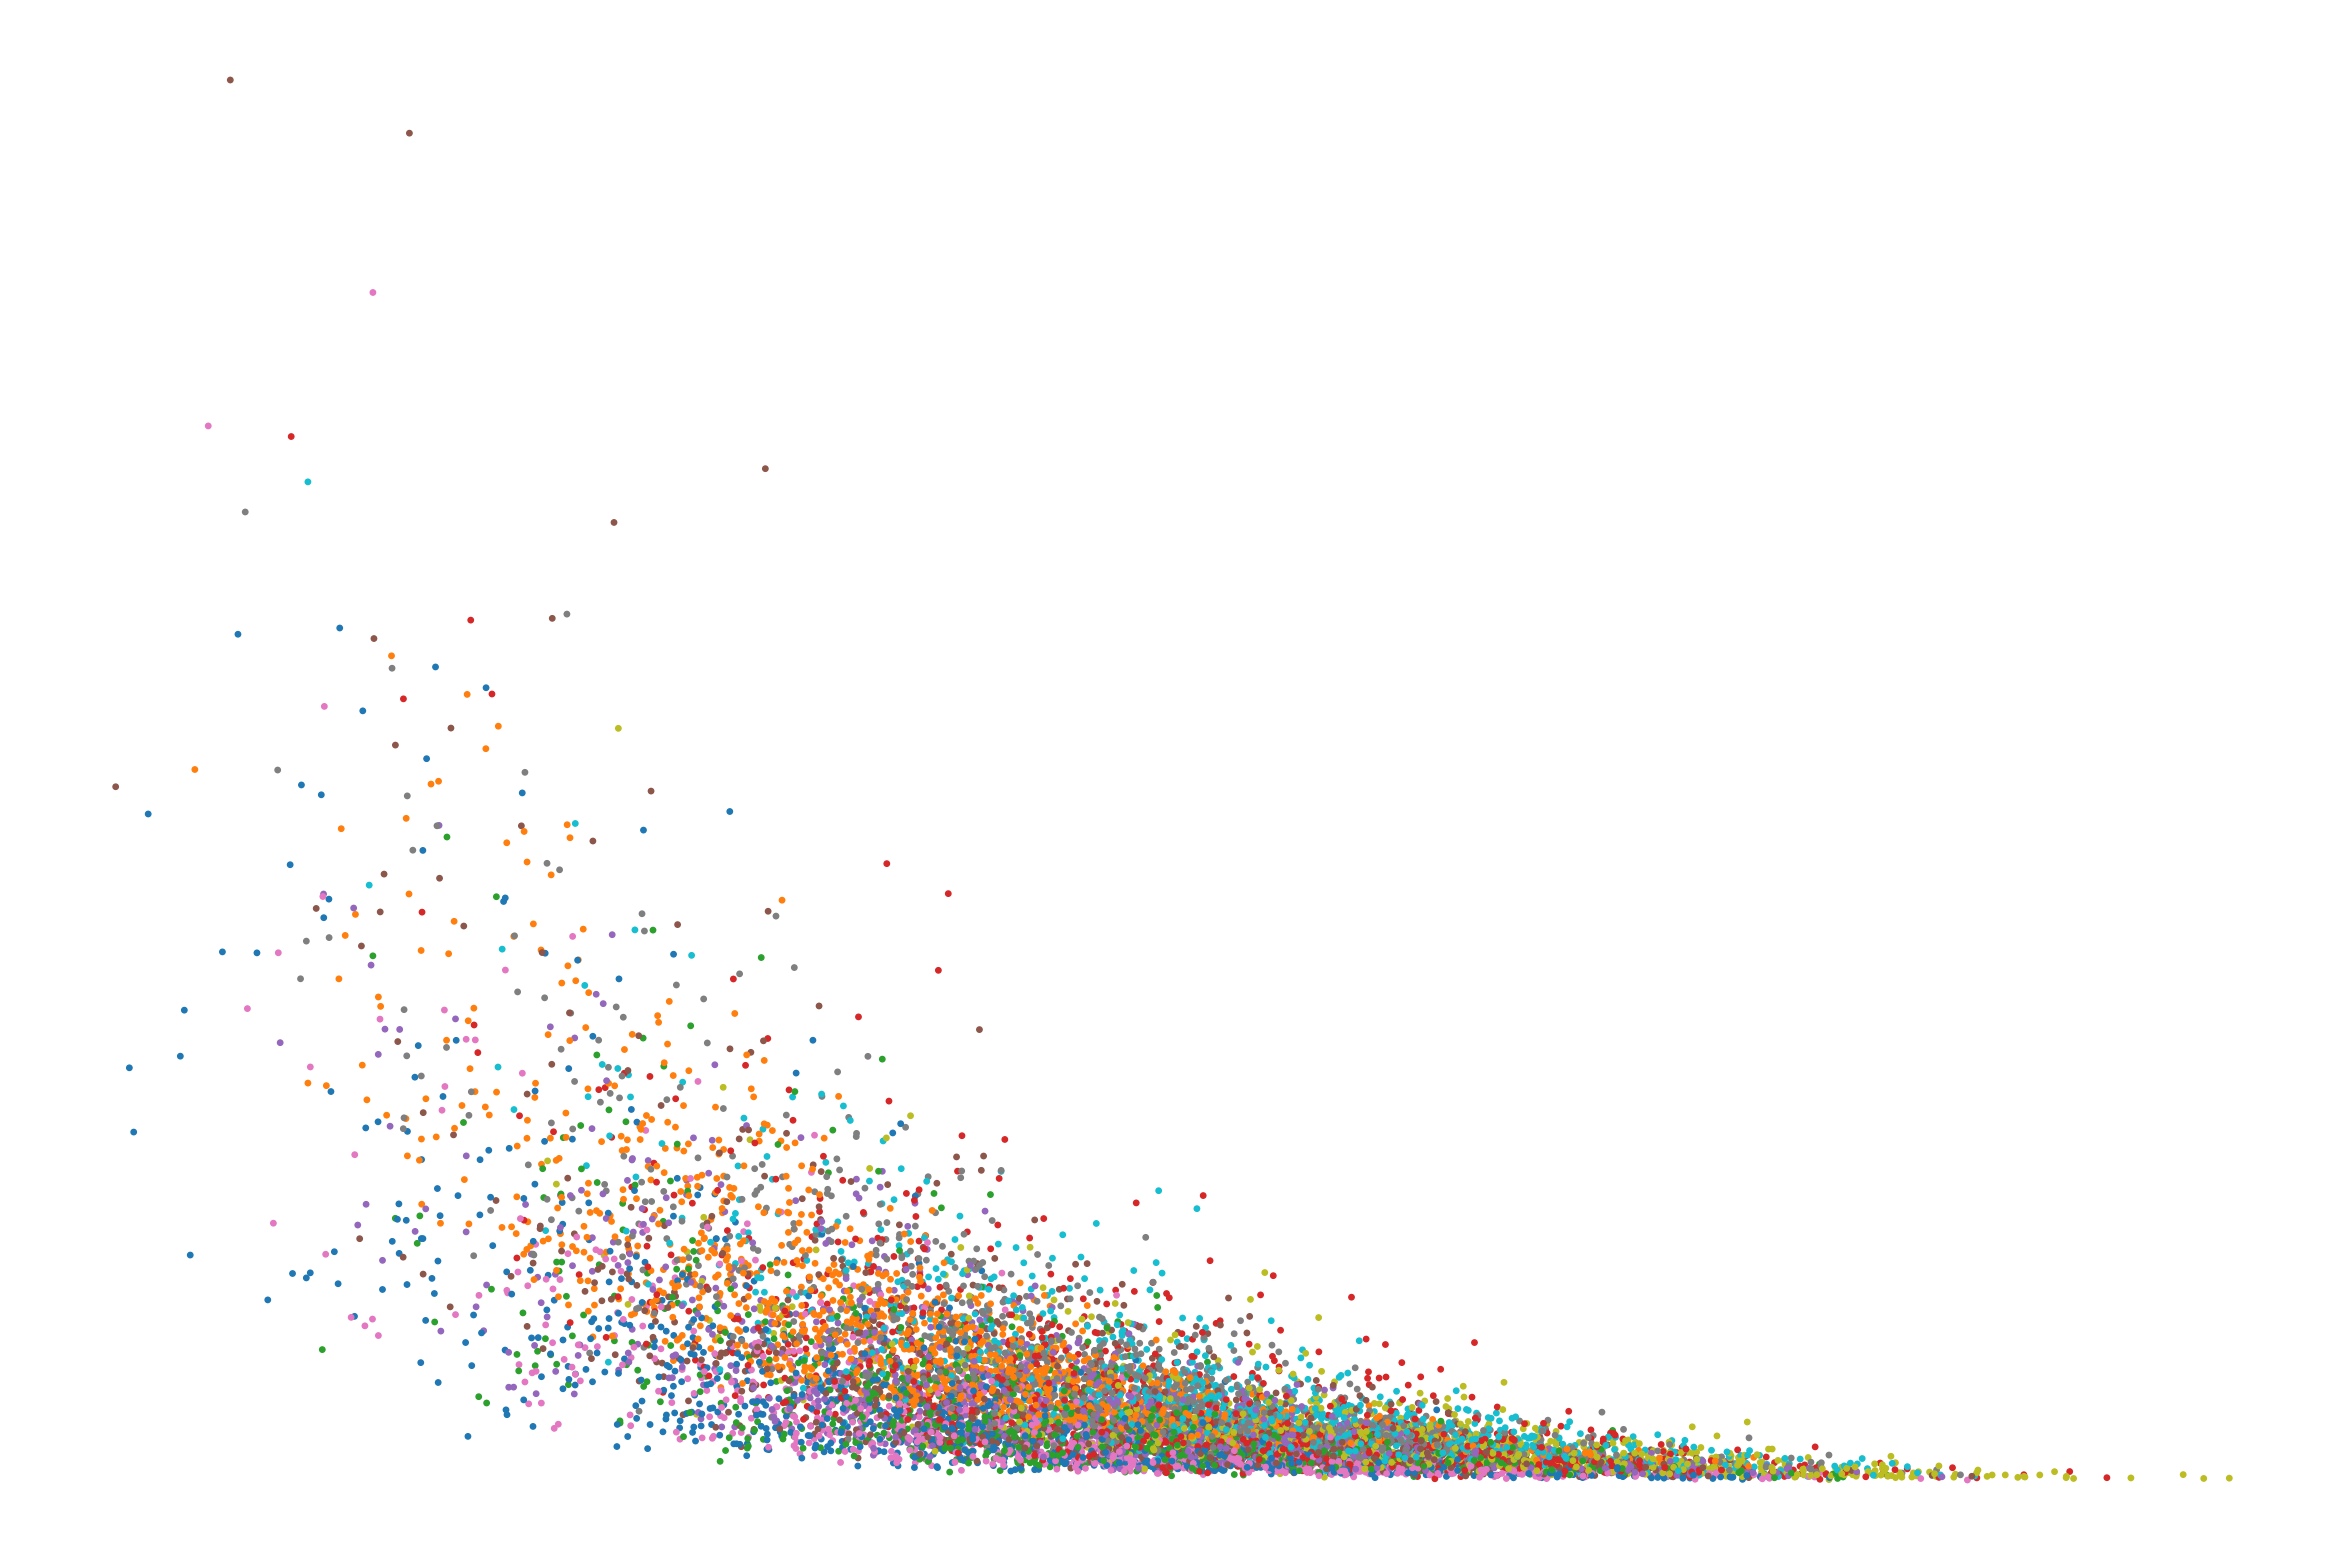

In [88]:
plt.figure(figsize=(30, 20))
plt.scatter(X_val_latent[:, 0], X_val_latent[:, 1], c=y_val, s=15, cmap='tab10')
plt.axis('off')

**We use the autoencoder to automatically perform dimensionality reduction on the 784-dimension image arrays to produce data of only 2-dimensions, which we can easily graph on a 2D plane, allowing us to visualize data graphically**

**We see clusters of data segregated from one another, showing that the model recognizes that ones are closer to other ones, twos are closer to other twos, etc.**

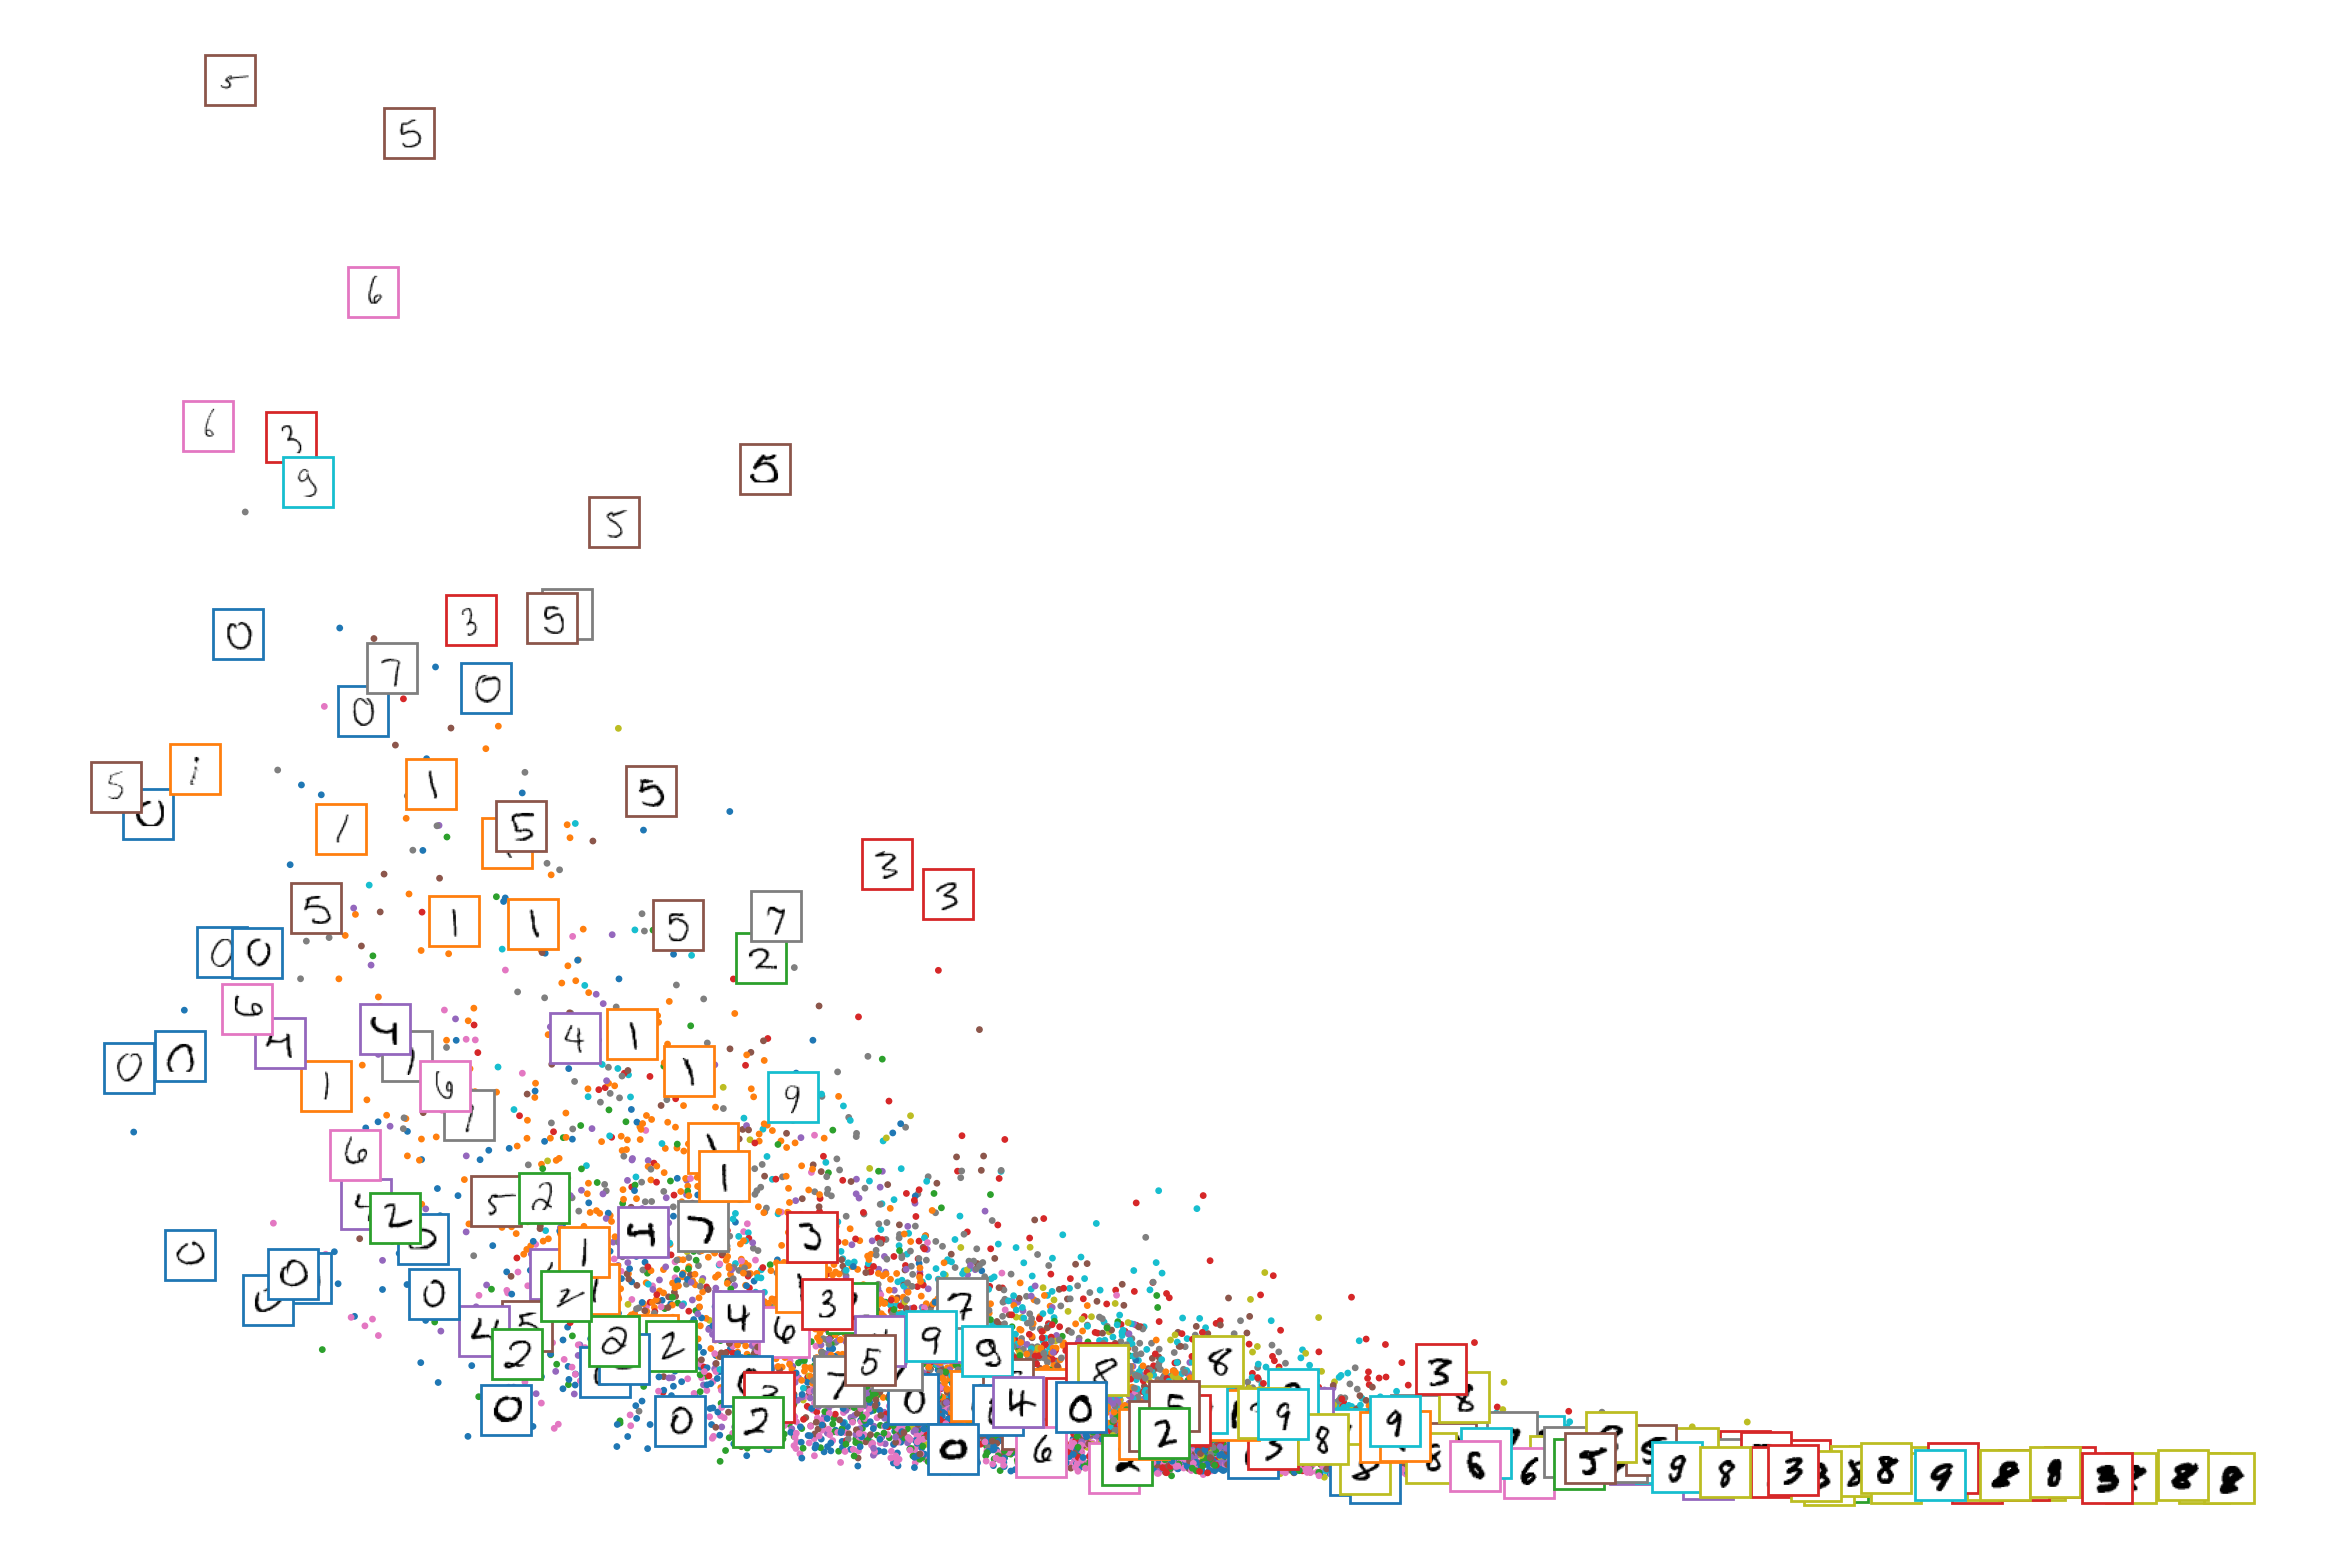

In [89]:
import matplotlib as mpl

plt.figure(figsize=(30, 20))
cmap = plt.cm.tab10
plt.scatter(X_val_latent[:, 0], X_val_latent[:, 1], c=y_val, s=15, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_val_latent):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_val[index].reshape(28, 28), cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_val[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()